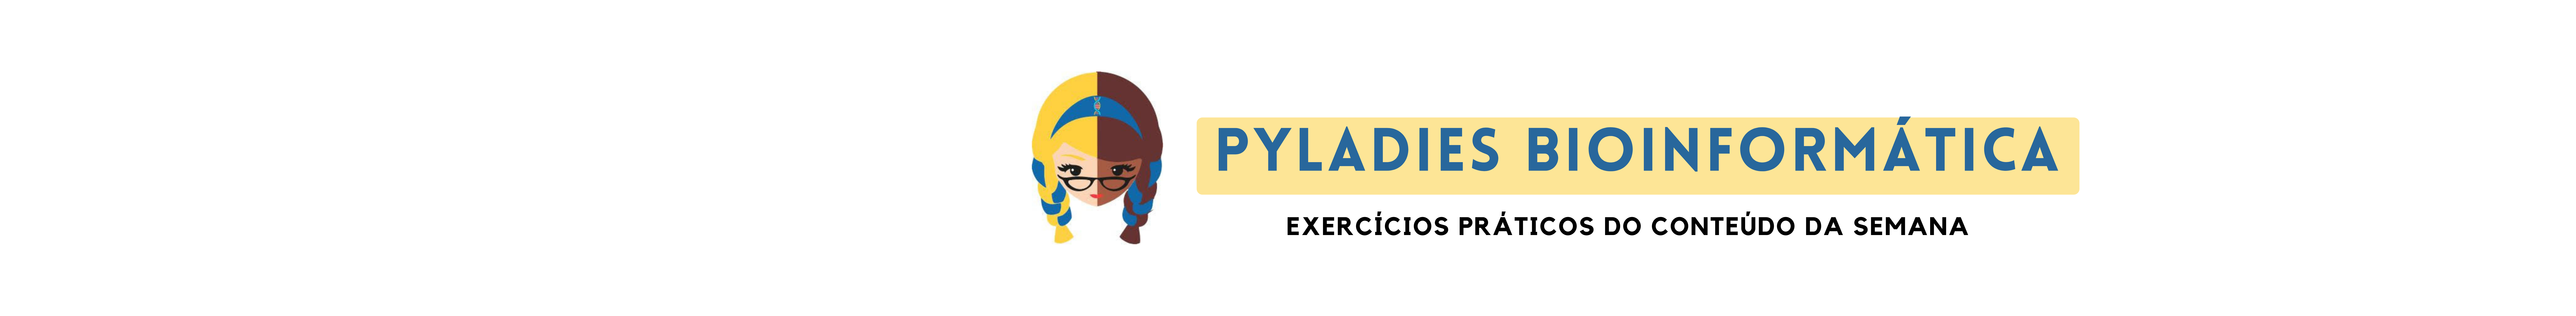


# Gene Expression Monitoring Analysis

## Introduction

In this notebook we shall examine a small gene expression dataset, attempting to classify leukemia patients into one of two classes. This dataset was the focus of a [Kaggle Days meetup](https://www.meetup.com/Kaggle-Days-Meetup-London/events/258570474/) in London that I attended in March 2019 and the original data can be found [here](https://www.kaggle.com/crawford/gene-expression). It comes with the following explanatory notes:

### Context
This dataset comes from a proof-of-concept study published in 1999 by Golub et al. It showed how new cases of cancer could be classified by gene expression monitoring (via DNA microarray) and thereby provided a general approach for identifying new cancer classes and assigning tumors to known classes. These data were used to classify patients with acute myeloid leukemia (AML) and acute lymphoblastic leukemia (ALL).

### Content
Golub et al "Molecular Classification of Cancer: Class Discovery and Class Prediction by Gene Expression Monitoring"

There are two datasets containing the initial (training, 38 samples) and independent (test, 34 samples) datasets used in the paper. These datasets contain measurements corresponding to ALL and AML samples from Bone Marrow and Peripheral Blood. Intensity values have been re-scaled such that overall intensities for each chip are equivalent.

### Acknowledgements
Molecular Classification of Cancer: Class Discovery and Class Prediction by Gene Expression

Science 286:531-537. (1999). Published: 1999.10.14

T.R. Golub, D.K. Slonim, P. Tamayo, C. Huard, M. Gaasenbeek, J.P. Mesirov, H. Coller, M. Loh, J.R. Downing, M.A. Caligiuri, C.D. Bloomfield, and E.S. Lander

These datasets have been converted to a comma separated value files (CSV).

### Inspiration
These datasets are great for classification problems. The original authors used the data to classify the type of cancer in each patient by their gene expressions.

## Data Preparation

In [ ]:
# Import all the libraries that we shall be using
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

In [ ]:
# Mount Google Drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Let's start by taking a look at our target, the ALL/AML label.

In [ ]:
# Import labels (for the whole dataset, both training and testing)
y = pd.read_csv('/content/drive/MyDrive/2 - Grupos de Estudos/2023 1/3. Python Avançado /Colabs/files_gene_expression/actual.csv')
print(y.shape)
y.head()

(72, 2)


,patient,cancer
0,1,ALL
1,2,ALL
2,3,ALL
3,4,ALL
4,5,ALL


In the combined training and testing sets there are 72 patients, each of whom are labelled either "ALL" or "AML" depending on the type of leukemia they have. Here's the breakdown:

In [ ]:
y['cancer'].value_counts()

ALL    47
AML    25
Name: cancer, dtype: int64

We actually need our labels to be numeric, so let's just do that now.

In [ ]:
# Recode label to numeric
y = y.replace({'ALL':0,'AML':1})
labels = ['ALL', 'AML'] # for plotting convenience later on

Now we move on to the features, which are provided for the training and testing datasets separately.

We can split our data into a training set and a testing set.

A common split is 80/20 or 70/30, where 80% or 70% of our data is used for training and the remaining 20% or 30% is used for testing.

Example:

Assuming X is the feature set and y is the target variable:

`from sklearn.model_selection import train_test_split`

`X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)`

The `test_size` parameter determines the proportion of the data that should be reserved for testing, and the `random_state` parameter ensures that the split is reproducible.


In [ ]:
# Import training data
df_train = pd.read_csv('/content/drive/MyDrive/2 - Grupos de Estudos/2023 1/3. Python Avançado /Colabs/files_gene_expression/data_set_ALL_AML_train.csv')
print(df_train.shape)

# Import testing data
df_test = pd.read_csv('/content/drive/MyDrive/2 - Grupos de Estudos/2023 1/3. Python Avançado /Colabs/files_gene_expression/data_set_ALL_AML_independent.csv')
print(df_test.shape)

(7129, 78)
(7129, 70)


In [ ]:
df_train.head()

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,5,call.4,6,call.5,7,call.6,8,call.7,9,call.8,10,call.9,11,call.10,12,call.11,13,call.12,14,call.13,15,call.14,16,call.15,17,call.16,18,call.17,19,call.18,20,call.19,21,call.20,22,call.21,23,call.22,24,call.23,25,call.24,26,call.25,27,call.26,34,call.27,35,call.28,36,call.29,37,call.30,38,call.31,28,call.32,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,-106,A,-138,A,-72,A,-413,A,5,A,-88,A,-165,A,-67,A,-92,A,-113,A,-107,A,-117,A,-476,A,-81,A,-44,A,17,A,-144,A,-247,A,-74,A,-120,A,-81,A,-112,A,-273,A,-20,A,7,A,-213,A,-25,A,-72,A,-4,A,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,-125,A,-85,A,-144,A,-260,A,-127,A,-105,A,-155,A,-93,A,-119,A,-147,A,-72,A,-219,A,-213,A,-150,A,-51,A,-229,A,-199,A,-90,A,-321,A,-263,A,-150,A,-233,A,-327,A,-207,A,-100,A,-252,A,-20,A,-139,A,-116,A,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,-76,A,215,A,238,A,7,A,106,A,42,A,-71,A,84,A,-31,A,-118,A,-126,A,-50,A,-18,A,-119,A,100,A,79,A,-157,A,-168,A,-11,A,-114,A,-85,A,-78,A,-76,A,-50,A,-57,A,136,A,124,A,-1,A,-125,A,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,168,A,71,A,55,A,-2,A,268,A,219,M,82,A,25,A,173,A,243,M,149,A,257,A,301,A,78,A,207,A,218,A,132,A,-24,A,-36,A,255,A,316,A,54,A,81,A,101,A,132,A,318,A,325,A,392,P,241,A,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,-230,A,-272,A,-399,A,-541,A,-210,A,-178,A,-163,A,-179,A,-233,A,-127,A,-205,A,-218,A,-403,A,-152,A,-146,A,-262,A,-151,A,-308,A,-317,A,-342,A,-418,A,-244,A,-439,A,-369,A,-377,A,-209,A,-396,A,-324,A,-191,A,-51,A,-139,A,-367,A,-188,A,-407,A


In [ ]:
df_test.head()

,Gene Description,Gene Accession Number,39,call,40,call.1,42,call.2,47,call.3,48,call.4,49,call.5,41,call.6,43,call.7,44,call.8,45,call.9,46,call.10,70,call.11,71,call.12,72,call.13,68,call.14,69,call.15,67,call.16,55,call.17,56,call.18,59,call.19,52,call.20,53,call.21,51,call.22,50,call.23,54,call.24,57,call.25,58,call.26,60,call.27,61,call.28,65,call.29,66,call.30,63,call.31,64,call.32,62,call.33
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-342,A,-87,A,22,A,-243,A,-130,A,-256,A,-62,A,86,A,-146,A,-187,A,-56,A,-55,A,-59,A,-131,A,-154,A,-79,A,-76,A,-34,A,-95,A,-12,A,-21,A,-202,A,-112,A,-118,A,-90,A,-137,A,-157,A,-172,A,-47,A,-62,A,-58,A,-161,A,-48,A,-176,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-200,A,-248,A,-153,A,-218,A,-177,A,-249,A,-23,A,-36,A,-74,A,-187,A,-43,A,-44,A,-114,A,-126,A,-136,A,-118,A,-98,A,-144,A,-118,A,-172,A,-13,A,-274,A,-185,A,-142,A,-87,A,-51,A,-370,A,-122,A,-442,A,-198,A,-217,A,-215,A,-531,A,-284,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,41,A,262,A,17,A,-163,A,-28,A,-410,A,-7,A,-141,A,170,A,312,A,43,A,12,A,23,A,-50,A,49,A,-30,A,-153,A,-17,A,59,A,12,A,8,A,59,A,24,A,212,A,102,A,-82,A,-77,A,38,A,-21,A,-5,A,63,A,-46,A,-124,A,-81,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,328,A,295,A,276,A,182,A,266,A,24,A,142,A,252,A,174,A,142,A,177,A,129,A,146,A,211,A,180,A,68,A,237,A,152,A,270,A,172,A,38,A,309,A,170,A,314,A,319,P,178,A,340,A,31,A,396,A,141,A,95,A,146,A,431,A,9,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-224,A,-226,A,-211,A,-289,A,-170,A,-535,A,-233,A,-201,A,-32,A,114,A,-116,A,-108,A,-171,A,-206,A,-257,A,-110,A,-215,A,-174,A,-229,A,-137,A,-128,A,-456,A,-197,A,-401,A,-283,A,-135,A,-438,A,-201,A,-351,A,-256,A,-191,A,-172,A,-496,A,-294,A


The 7129 gene descriptions are provided as the rows and the values for each patient as the columns. This will clearly require some tidying up.

Our first decision is: What should we do about all the "call" columns, one for each patient. No explanation for these is provided, so it's difficult to know whether they might be useful or not. We have taken the decision to simply remove them, but this may possibly not be the best approach.

In [ ]:
# Transform all the call values to numbers (not used in this version)
# df_train.replace(['A','P','M'],['1','2','3'], inplace=True)
# df_test.replace(['A','P','M'],['1','2','3'], inplace=True)

# Remove "call" columns from training and testing data
train_to_keep = [col for col in df_train.columns if "call" not in col]
test_to_keep = [col for col in df_test.columns if "call" not in col]

X_train_tr = df_train[train_to_keep]
X_test_tr = df_test[test_to_keep]

Neither the training and testing column names are not in numeric order, so it's important that we reorder these at some point, so that the labels will line up with the corresponding data.

In [ ]:
train_columns_titles = ['Gene Description', 'Gene Accession Number', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
       '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38']

X_train_tr = X_train_tr.reindex(columns=train_columns_titles)

In [ ]:
test_columns_titles = ['Gene Description', 'Gene Accession Number','39', '40', '41', '42', '43', '44', '45', '46',
       '47', '48', '49', '50', '51', '52', '53',  '54', '55', '56', '57', '58', '59',
       '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72']

X_test_tr = X_test_tr.reindex(columns=test_columns_titles)

Now we can simply transpose the columns and rows so that genes become features and each patient's observations occupies a single row.

In [ ]:
X_train = X_train_tr.T
X_test = X_test_tr.T

print(X_train.shape)
X_train.head()

(40, 7129)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,7089,7090,7091,7092,7093,7094,7095,7096,7097,7098,7099,7100,7101,7102,7103,7104,7105,7106,7107,7108,7109,7110,7111,7112,7113,7114,7115,7116,7117,7118,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
Gene Description,AFFX-BioB-5_at (endogenous control),AFFX-BioB-M_at (endogenous control),AFFX-BioB-3_at (endogenous control),AFFX-BioC-5_at (endogenous control),AFFX-BioC-3_at (endogenous control),AFFX-BioDn-5_at (endogenous control),AFFX-BioDn-3_at (endogenous control),AFFX-CreX-5_at (endogenous control),AFFX-CreX-3_at (endogenous control),AFFX-BioB-5_st (endogenous control),AFFX-BioB-M_st (endogenous control),AFFX-BioB-3_st (endogenous control),AFFX-BioC-5_st (endogenous control),AFFX-BioC-3_st (endogenous control),AFFX-BioDn-5_st (endogenous control),AFFX-BioDn-3_st (endogenous control),AFFX-CreX-5_st (endogenous control),AFFX-CreX-3_st (endogenous control),hum_alu_at (miscellaneous control),AFFX-DapX-5_at (endogenous control),AFFX-DapX-M_at (endogenous control),AFFX-DapX-3_at (endogenous control),AFFX-LysX-5_at (endogenous control),AFFX-LysX-M_at (endogenous control),AFFX-LysX-3_at (endogenous control),AFFX-PheX-5_at (endogenous control),AFFX-PheX-M_at (endogenous control),AFFX-PheX-3_at (endogenous control),AFFX-ThrX-5_at (endogenous control),AFFX-ThrX-M_at (endogenous control),AFFX-ThrX-3_at (endogenous control),AFFX-TrpnX-5_at (endogenous control),AFFX-TrpnX-M_at (endogenous control),AFFX-TrpnX-3_at (endogenous control),AFFX-HUMISGF3A/M97935_5_at (endogenous control),AFFX-HUMISGF3A/M97935_MA_at (endogenous control),AFFX-HUMISGF3A/M97935_MB_at (endogenous control),AFFX-HUMISGF3A/M97935_3_at (endogenous control),AFFX-HUMRGE/M10098_5_at (endogenous control),AFFX-HUMRGE/M10098_M_at (endogenous control),...,GB DEF = SPR2-1 gene for small proline rich pr...,Metallothionein,GB DEF = Glutamate dehydrogenase,PRSS3 Protease; serine; 3 (trypsin 3),GB DEF = Transmembrane protein Tmp21-IIex,GB DEF = H2B/h gene,ACTB Actin; beta,GAPD Glyceraldehyde-3-phosphate dehydrogenase,CYTOCHROME P450 IA2,Nkat2b mRNA,Natural killer cell receptor (KIR) mRNA,Major Histocompatibility Complex; Class I; C (...,HLA-A MHC class I protein HLA-A (HLA-A28;-B40;...,PRB2 locus salivary proline-rich protein mRNA;...,HLA CLASS II HISTOCOMPATIBILITY ANTIGEN; DQ(W1...,GB DEF = (HLCC85) mRNA for voltage-dependent L...,GB DEF = Endogenous retrovirus clone P1.8 poly...,Integrase gene extracted from Human endogenous...,WUGSC:GS345D13.2 gene (G-protein gamma-1 subun...,TIAL1 TIA1 cytotoxic granule-associated RNA-bi...,Ras-Specific Guanine Nucleotide-Releasing Factor,TYROSINE-PROTEIN KINASE ITK/TSK,(clone p4) 50 kD dystrophin-associated glycopr...,Ifp35 gene extracted from Human BRCA1; Rho7 an...,INHA Inhibin; alpha,S100A9 S100 calcium-binding protein A9 (calgra...,PLGL Plasminogen-like protein,ID1 Inhibitor of DNA binding 1; dominant negat...,ABP1 Amiloride binding protein 1 (amine oxidas...,Transcriptional activator hSNF2b,Transcription factor Stat5b (stat5b) mRNA,Breast epithelial antigen BA46 mRNA,GB DEF = Calcium/calmodulin-dependent protein ...,TUBULIN ALPHA-4 CHAIN,CYP4B1 Cytochrome P450; subfamily IVB; polypep...,PTGER3 Prostaglandin E receptor 3 (subtype EP3...,HMG2 High-mobility group (nonhistone chromosom...,RB1 Retinoblastoma 1 (including osteosarcoma),GB DEF = Glycophorin Sta (type A) exons 3 and ...,GB DEF = mRNA (clone 1A7)
Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,AFFX-BioB-M_st,AFFX-BioB-3_st,AFFX-BioC-5_st,AFFX-BioC-3_st,AFFX-BioDn-5_st,AFFX-BioDn-3_st,AFFX-CreX-5_st,AFFX-CreX-3_st,hum_alu_at,AFFX-DapX-5_at,AFFX-DapX-M_at,AFFX-DapX-3_at,AFFX-LysX-5_at,AFFX-LysX-M_at,AFFX-LysX-3_at,AFFX-PheX-5_at,AFFX-PheX-M_at,AFFX-PheX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-ThrX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at,AFFX-TrpnX-

This is still messy as the first two rows are more or less duplicates of one another and we haven't yet created the column names. Let's simply turn the second row into the column names and delete the first row.

In [ ]:
# Clean up the column names for training and testing data
X_train.columns = X_train.iloc[1]
X_train = X_train.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

# Clean up the column names for Testing data
X_test.columns = X_test.iloc[1]
X_test = X_test.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

print(X_train.shape)
print(X_test.shape)
X_train.head()

(38, 7129)
(34, 7129)


Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,AFFX-BioB-M_st,AFFX-BioB-3_st,AFFX-BioC-5_st,AFFX-BioC-3_st,AFFX-BioDn-5_st,AFFX-BioDn-3_st,AFFX-CreX-5_st,AFFX-CreX-3_st,hum_alu_at,AFFX-DapX-5_at,AFFX-DapX-M_at,AFFX-DapX-3_at,AFFX-LysX-5_at,AFFX-LysX-M_at,AFFX-LysX-3_at,AFFX-PheX-5_at,AFFX-PheX-M_at,AFFX-PheX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-ThrX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at,AFFX-TrpnX-3_at,AFFX-HUMISGF3A/M97935_5_at,AFFX-HUMISGF3A/M97935_MA_at,AFFX-HUMISGF3A/M97935_MB_at,AFFX-HUMISGF3A/M97935_3_at,AFFX-HUMRGE/M10098_5_at,AFFX-HUMRGE/M10098_M_at,...,X53065_f_at,X64177_f_at,X67491_f_at,X71345_f_at,X97444_f_at,Z80780_f_at,X00351_f_at,X01677_f_at,M31667_f_at,L41268_f_at,X99479_f_at,HG658-HT658_f_at,M94880_f_at,S80905_f_at,X03068_f_at,Z34822_f_at,U87593_f_at,U88902_cds1_f_at,AC002076_cds2_at,D64015_at,HG2510-HT2606_at,L10717_at,L34355_at,L78833_cds4_at,M13981_at,M21064_at,M93143_at,S78825_at,U11863_at,U29175_at,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,-41,-831,-653,-462,75,381,-118,-565,15091,7,311,-231,21,-107,165,-78,-204,29,-61,-105,-366,-41,-346,-297,-109,-13,215,797,14538,9738,...,391,-763,172,149,341,788,21210,13771,598,396,245,14476,10882,701,2762,-325,-67,346,-68,229,-14,108,28,349,61,273,384,-306,-1827,1582,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,19,-743,-239,-83,182,164,-141,-423,11038,37,134,-161,-21,-180,18,-120,-65,97,15,-49,-330,-41,-772,-259,-192,-219,116,433,615,115,...,200,51,154,418,433,736,21059,15097,563,171,-149,13686,11789,76,1567,-191,-88,290,14,194,56,303,-242,214,-28,143,231,-336,-2380,624,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,19,-1135,-962,-232,208,432,84,-501,16692,183,378,-221,67,-203,238,-124,-161,36,-23,-80,-481,-65,-620,-269,-136,104,476,1474,5669,3272,...,387,-474,180,272,591,959,24292,17378,1808,363,325,6560,5023,804,1090,-258,9,220,-58,294,95,143,-25,464,513,238,720,-204,-1772,753,315,1199,33,168,52,1138,777,41,228,-41
4,-135,-114,265,12,-419,-585,158,-253,49,31,363,-934,-577,-214,142,271,-107,-101,15763,45,268,-27,43,-52,247,-116,-208,22,-10,-74,-240,-33,-560,-261,-366,-148,155,415,4850,2293,...,317,-336,325,149,173,431,17558,13818,576,455,594,8955,9567,367,1708,-357,45,430,-35,128,42,22,-131,342,142,277,307,-320,-2022,743,240,835,218,174,-110,627,170,-50,126,-91
5,-106,-125,-76,168,-230,-284,4,-122,70,252,155,-471,-490,-184,32,213,1,-260,18128,-28,118,-153,-8,-111,44,-88,-102,32,5,-18,-228,53,-348,-169,-156,-55,122,483,1284,2731,...,162,-56,279,183,259,605,18530,15619,65,122,126,8443,8512,182,1503,-78,29,159,18,71,42,44,-33,159,71,134,178,-182,-179,626,156,649,57,504,-26,250,314,14,56,-25


That looks much better. We have the 38 patients as rows in the training set, and the other 34 as rows in the testing set. Each of those datasets has 7129 gene expression features.

But we haven't yet associated the target labels with the right patients. You will recall that all the labels are all stored in a single dataframe. Let's split the data so that the patients and labels match up across the training and testing dataframes.

In [ ]:
# Split into train and test (we first need to reset the index as the indexes of two dataframes need to be the same before you combine them).

# Subset the first 38 patient's cancer types
X_train = X_train.reset_index(drop=True)
y_train = y[y.patient <= 38].reset_index(drop=True)

# Subset the rest for testing
X_test = X_test.reset_index(drop=True)
y_test = y[y.patient > 38].reset_index(drop=True)

Let's now take a look at some summary statistics:

In [ ]:
X_train.describe()

Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,AFFX-BioB-M_st,AFFX-BioB-3_st,AFFX-BioC-5_st,AFFX-BioC-3_st,AFFX-BioDn-5_st,AFFX-BioDn-3_st,AFFX-CreX-5_st,AFFX-CreX-3_st,hum_alu_at,AFFX-DapX-5_at,AFFX-DapX-M_at,AFFX-DapX-3_at,AFFX-LysX-5_at,AFFX-LysX-M_at,AFFX-LysX-3_at,AFFX-PheX-5_at,AFFX-PheX-M_at,AFFX-PheX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-ThrX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at,AFFX-TrpnX-3_at,AFFX-HUMISGF3A/M97935_5_at,AFFX-HUMISGF3A/M97935_MA_at,AFFX-HUMISGF3A/M97935_MB_at,AFFX-HUMISGF3A/M97935_3_at,AFFX-HUMRGE/M10098_5_at,AFFX-HUMRGE/M10098_M_at,...,X53065_f_at,X64177_f_at,X67491_f_at,X71345_f_at,X97444_f_at,Z80780_f_at,X00351_f_at,X01677_f_at,M31667_f_at,L41268_f_at,X99479_f_at,HG658-HT658_f_at,M94880_f_at,S80905_f_at,X03068_f_at,Z34822_f_at,U87593_f_at,U88902_cds1_f_at,AC002076_cds2_at,D64015_at,HG2510-HT2606_at,L10717_at,L34355_at,L78833_cds4_at,M13981_at,M21064_at,M93143_at,S78825_at,U11863_at,U29175_at,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,...,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000
mean,-120.868421,-150.526316,-17.157895,181.394737,-276.552632,-439.210526,-43.578947,-201.184211,99.052632,112.131579,67.947368,-701.105263,-492.868421,-194.394737,110.263158,189.894737,-70.868421,-342.105263,20276.657895,29.210526,170.315789,-95.421053,19.131579,-151.763158,89.631579,-91.631579,-134.157895,-7.368421,-21.184211,-48.447368,-278.342105,7.184211,-550.710526,-245.447368,-206.921053,-2.026316,214.236842,765.263158,4133.368421,2576.315789,...,268.815789,-365.921053,271.210526,483.078947,396.631579,463.342105,17991.447368,16025.789474,819.473684,292.868421,171.894737,10554.526316,9033.710526,396.921053,2495.921053,-230.894737,10.763158,319.105263,-9.105263,222.815789,53.421053,73.368421,-21.368421,266.789474,128.842105,220.105263,334.605263,-273.684211,-1678.842105,965.263158,178.763158,750.842105,8.815789,399.131579,-20.052632,869.052632,335.842105,19.210526,504.394737,-29.210526
std,109.555656,75.734507,117.686144,117.468004,111.004431,135.458412,219.482393,90.838989,83.178397,211.815597,168.362535,235.446647,219.930231,124.907001,136.108995,132.304683,70.325179,193.686957,7546.053808,81.206829,101.666946,60.176152,38.604839,108.490237,80.849684,45.844285,57.983468,65.672990,51.336124,38.629003,115.244576,54.755405,156.187155,68.982841,135.338890,439.362037,315.278636,737.537381,5690.572471,4141.001342,...,99.401413,657.032369,228.186168,1462.672459,161.848515,469.653022,5782.493541,3883.585841,530.540303,159.607317,248.903410,3581.291657,3982.630931,321.125502,1986.098340,95.769653,66.839636,188.752775,52.387222,111.896394,46.237712,62.082082,201.001737,128.158719,124.958485,92.496542,172.760503,166.168281,929.175064,754.069489,84.826830,298.008392,77.108507,469.579868,42.346031,482.366461,209.826766,31.158841,728.744405,30.851132
min,-476.000000,-327.000000,-307.000000,-36.000000,-541.000000,-790.000000,-479.000000,-463.000000,-82.000000,-215.000000,-209.000000,-1250.000000,-962.000000,-541.000000,-96.000000,-156.000000,-179.000000,-874.000000,6479.000000,-126.000000,-39.0

Clearly there is some variation in the scales across the different features. Many machine learning models work much better with data that's on the same scale, so let's create a scaled version of the dataset.

In [ ]:
# Convert from integer to float
X_train_fl = X_train.astype(float, 64)
X_test_fl = X_test.astype(float, 64)

# Apply the same scaling to both datasets
scaler = StandardScaler()
X_train_scl = scaler.fit_transform(X_train_fl)
X_test_scl = scaler.transform(X_test_fl) # note that we transform rather than fit_transform

**Pré-processamento**

- Boas práticas
   - dividir em notebooks:
    - limpeza
    - análise exploratória
    - transformação e seleção
    - modelagem

**Limpeza**
- Tratamento de valores ausentes
- Tratamento de outiliers (cuidado ao se tratar de genes, outiliers podem ser importantes)

**Transformação**
- Criação de atributos novos
- Modificações do tipo da variável
  - Categóricas
    - One-Hot Encoding
    - Label Encoding
  - Numéricas
    - Binarização
    - Discretização
- Escalonamento
  - min_max()
  - logaritmização
  - Padronização (transformação Z-score)
  - Normalização

**Redução da dimensionalidade [Projeção, Seleção]**
- Correlação
- Anova
- Regressão
- Árvores de decisão
- Análise de Componentes principais (PCA)

**Análise de correlação (análise exploratória)**


In [ ]:
# Quantos genes tiveram expressão 0?
# Fiz isso antes de perceber que na verdade o valor de expressão está em relação
# à uma amostra controle ([+]: upregulados, [-]: downregulados)
# X_train_fl.iloc[:, list(X_train_fl.sum() != 0)]

In [ ]:
# Quantos genes tiveram um comportamento outiler em pacientes (ALL, AML)?

In [ ]:
# Quantos genes tiveram perfil correlacionado nos pacientes?
# Defini que genes com correlação >= |0.7| tem indícios significativos
# de uma correlação forte

from tqdm import tqdm

X_train_corr = X_train_fl.corr()
X_train_corr = X_train_corr.to_numpy(na_value=0)
X_train_corr = np.triu(X_train_corr, 1)

# get gene gene interaction best correlation
var1 = []
var2 = []
corr = []
genes = list(X_train_fl.columns)
treshold = 0.7

for i in tqdm(range(len(X_train_corr))):
    for j in range(len(X_train_corr)):
        if abs(X_train_corr[i, j]) >= treshold:
            var1.append(genes[i])
            var2.append(genes[j])
            corr.append(X_train_corr[i, j])

corr_var_to_var = pd.DataFrame({'Var1': var1, 'Var2': var2, 'Correlation': corr})

100%|██████████| 7129/7129 [00:24<00:00, 295.64it/s]


In [ ]:
corr_var_to_var.head()

,Var1,Var2,Correlation
0,AFFX-BioC-3_at,AFFX-BioDn-5_at,0.743706
1,AFFX-BioC-3_at,D83195_at,0.700101
2,AFFX-BioC-3_at,HG4332-HT4602_at,-0.711360
3,AFFX-BioC-3_at,L33798_at,0.713739
4,AFFX-BioC-3_at,M65199_at,0.739727


In [ ]:
print(f'\n{corr_var_to_var.shape[0]} interações gene-gene com correlação >= |{treshold}|')


80742 interações gene-gene com correlação >= |0.7|


In [ ]:
lista_total_genes = pd.concat([corr_var_to_var['Var1'], corr_var_to_var['Var2']]).unique().tolist()
print(f'{len(lista_total_genes)} tiveram pelo menos uma correlação forte com outro gene')


4413 tiveram pelo menos uma correlação forte com outro gene


In [ ]:
from collections import Counter
from operator import itemgetter
from itertools import islice

lista_total_genes = pd.concat([corr_var_to_var['Var1'], corr_var_to_var['Var2']]).tolist()
contagem_genes = Counter(lista_total_genes)
contagem_genes_ordenada = dict(sorted(contagem_genes.items(), key=itemgetter(1), reverse=True))

for chave, valor in islice(contagem_genes_ordenada.items(), 20):
    print(f'{valor} interações fortes: {chave}')

397 interações fortes: X65962_s_at
384 interações fortes: X95190_at
382 interações fortes: U82311_at
376 interações fortes: U82320_at
369 interações fortes: X92518_s_at
365 interações fortes: X79981_at
338 interações fortes: U65928_at
329 interações fortes: X13444_at
319 interações fortes: X82895_at
318 interações fortes: S83513_s_at
314 interações fortes: U80987_s_at
312 interações fortes: U79291_at
311 interações fortes: X98253_at
308 interações fortes: U45982_at
307 interações fortes: M91432_at
306 interações fortes: U62136_at
294 interações fortes: D80006_at
293 interações fortes: U39905_at
291 interações fortes: M92439_at
291 interações fortes: X05855_s_at


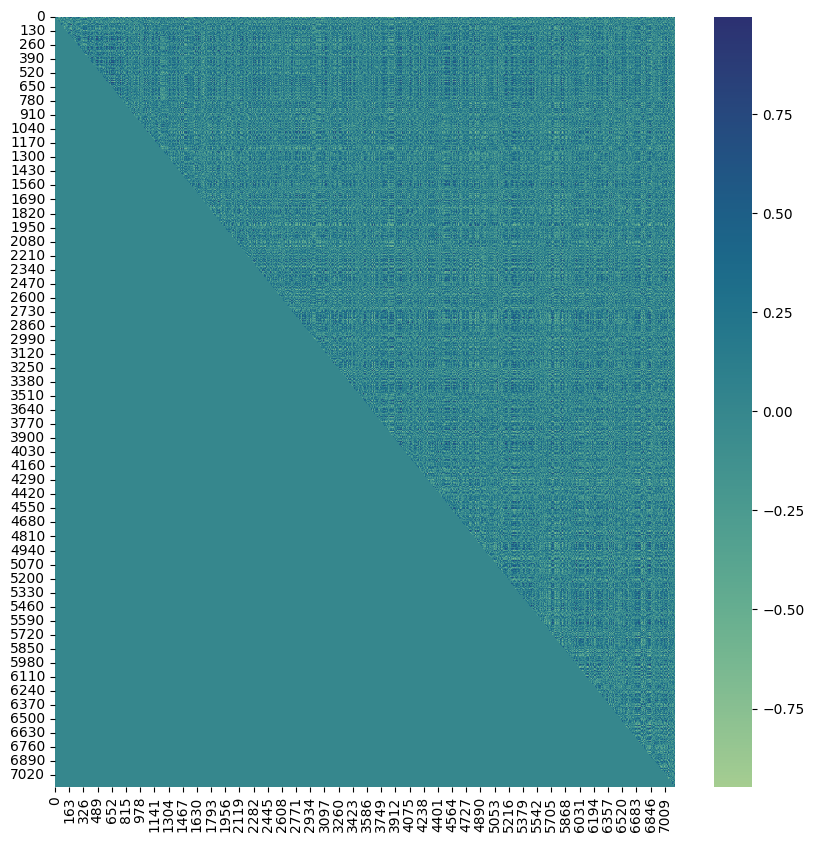

In [ ]:
# mask = np.triu(np.ones_like(X_train_corr, dtype=bool))

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(X_train_corr, cmap='crest')
plt.show()

**Perguntas**
- Existem diferenças nos perfis de genes correlacionados nas condições ALL e ALM?

**Conclusões**
- Não usarei a correlação para selecionar/excluir atributos [genes] uma vez que mais de 4000 genes apresentam alguma interação forte com outro gene.

**Próximos passos**
- No entanto, após análise de variância ou regressão eu conseguiria cruzar esses dados para tentar entender como a correlação destes genes afeta a importância deles para o modelo.
- Binarizar os atributos (genes) e avaliar se o fato do gene estar up (1) ou downregulado (0) afeta a sua importância para o modelo.

## PCA

A Análise de Componentes Principais (ACP) é uma técnica estatística utilizada para simplificar e resumir conjuntos de dados multivariados. Ela busca encontrar os principais componentes subjacentes aos dados, capturando a maior parte da variabilidade dos mesmos. Esses componentes são combinações lineares das variáveis originais e são ordenados de forma que o primeiro componente principal explique a maior variação nos dados, o segundo componente principal explique a segunda maior variação e assim por diante.
A ACP é usada principalmente para reduzir a dimensionalidade dos dados, ou seja, para representar os dados em um espaço de menor dimensão, enquanto se preserva o máximo de informações possível. Isso é especialmente útil quando se trabalha com conjuntos de dados que possuem muitas variáveis, permitindo uma visualização mais clara e uma análise mais eficiente.

O processo de ACP envolve várias etapas:
1. Padronização dos dados: Os dados são tipicamente padronizados para que todas as variáveis tenham a mesma escala. Isso é importante porque as variáveis podem ter diferentes unidades de medida e escalas, o que poderia afetar a análise.
2. Cálculo da matriz de covariância ou matriz de correlação: A matriz de covariância é calculada quando as variáveis têm unidades de medida comparáveis, enquanto a matriz de correlação é usada quando as unidades de medida são diferentes. Essas matrizes capturam as relações entre as variáveis originais.
3. Cálculo dos componentes principais: Os componentes principais são calculados a partir da matriz de covariância ou matriz de correlação. Isso é feito encontrando os autovetores e autovalores da matriz. Os autovetores representam as direções dos componentes principais, enquanto os autovalores indicam a quantidade de variação explicada por cada componente principal.
4. Seleção dos componentes principais: Os componentes principais são ordenados de acordo com os autovalores correspondentes, em ordem decrescente. Geralmente, seleciona-se um número menor de componentes principais que capturem a maior parte da variabilidade dos dados. Isso pode ser feito com base em critérios como a variância explicada acumulada ou através de técnicas de quebra de ponto de inflexão.
5. Projeção dos dados: Os dados originais são projetados no espaço dos componentes principais selecionados. Essa projeção envolve calcular as combinações lineares das variáveis originais com os coeficientes dos componentes principais.

A ACP tem diversas aplicações, como redução de dimensionalidade, visualização de dados, remoção de ruído, detecção de outliers e análise de correlação entre variáveis. É uma técnica poderosa que permite explorar a estrutura subjacente dos dados e simplificar a análise de conjuntos de dados complexos.

A equação matemática da Análise de Componentes Principais (ACP) envolve o cálculo dos componentes principais a partir dos dados originais. Vou explicar a equação para o caso da matriz de covariância, que é uma das abordagens mais comuns na ACP.

Suponha que tenhamos um conjunto de dados com n observações e p variáveis. Podemos representar esses dados em uma matriz X de dimensão n x p, em que cada linha representa uma observação e cada coluna representa uma variável.

A ACP busca encontrar um conjunto de p componentes principais que capturem a maior parte da variabilidade dos dados. Os componentes principais são combinações lineares das variáveis originais.

A equação para o cálculo dos componentes principais é dada por:

`Z = X * V`

Nessa equação, Z é uma matriz de dimensão n x p, que representa os componentes principais. Cada coluna de Z é um componente principal, e as linhas correspondem às observações. X é a matriz de dados originais, e V é uma matriz de dimensão p x p, que contém os autovetores da matriz de covariância.

Para calcular a matriz V, primeiro calculamos a matriz de covariância C de dimensão p x p:

`C = (1/n) * (X^T * X)``

Nessa equação, X^T é a matriz transposta de X. Em seguida, encontramos os autovetores e autovalores da matriz de covariância C. Os autovetores de C formam a matriz V, em que cada coluna corresponde a um autovetor.
Os componentes principais são obtidos multiplicando a matriz de dados X pela matriz de autovetores V. Essa multiplicação de matrizes realiza as combinações lineares das variáveis originais, gerando os componentes principais.

Após obter os componentes principais, é possível selecionar um subconjunto deles com base nos autovalores correspondentes. Geralmente, escolhemos os componentes principais com os maiores autovalores, pois eles explicam a maior parte da variabilidade dos dados.

A equação matemática da ACP é essencialmente uma representação matricial dos cálculos necessários para obter os componentes principais a partir dos dados originais. Ela permite resumir e representar a estrutura subjacente dos dados em um espaço de menor dimensão.

- Python
Análise de Componentes Principais (ACP) utilizando a biblioteca scikit-learn em Python. A biblioteca scikit-learn possui uma implementação fácil e eficiente da ACP.
Antes de começarmos, certifique-se de ter o scikit-learn instalado em seu ambiente. Você pode instalar utilizando o comando pip install scikit-learn.
Aqui está um exemplo de código que demonstra como realizar a ACP em Python:

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

# Crie uma matriz de dados de exemplo
X = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]])

# Inicialize o objeto PCA e especifique o número de componentes principais desejados
pca = PCA(n_components=2)

# Ajuste o modelo aos dados e obtenha os componentes principais
pca.fit(X)
componentes_principais = pca.transform(X)

# Variância explicada pelos componentes principais
var_explicada = pca.explained_variance_ratio_
var_explicada_acumulada = np.cumsum(var_explicada)

# Print dos resultados
print("Componentes Principais:")
print(componentes_principais)
print("Variância Explicada:")
print(var_explicada)
print("Variância Explicada Acumulada:")
print(var_explicada_acumulada)

Componentes Principais:
[[-7.79422863e+00 -1.66533454e-15]
 [-2.59807621e+00 -5.55111512e-16]
 [ 2.59807621e+00  5.55111512e-16]
 [ 7.79422863e+00  1.66533454e-15]]
Variância Explicada:
[1. 0.]
Variância Explicada Acumulada:
[1. 1.]


Neste exemplo, criamos uma matriz de dados de exemplo X, com 4 observações e 3 variáveis. Em seguida, inicializamos um objeto PCA com n_components=2, ou seja, queremos obter os dois primeiros componentes principais.
Depois, ajustamos o modelo aos dados utilizando pca.fit(X) e obtemos os componentes principais utilizando pca.transform(X).
Para calcular a variância explicada, utilizamos pca.explained_variance_ratio_, que retorna a proporção da variância explicada por cada componente principal. Em seguida, utilizamos np.cumsum() para calcular a variância explicada acumulada.
Finalmente, imprimimos os componentes principais, a variância explicada e a variância explicada acumulada.

With 7129 features, it's also worth considering whether we might be able to reduce the dimensionality of the dataset. Once very common approach to this is principal components analysis (PCA). Let's start by leaving the number of desired components as an open question:

In [ ]:
pca = PCA()
pca.fit_transform(X_train)

array([[-4.12032149e+03,  8.43574289e+03, -1.39441668e+04, ...,
         2.51106855e+03,  3.92187680e+03,  1.22642865e-11],
       [ 1.86283598e+04,  1.44078238e+04,  1.66177453e+04, ...,
        -2.30960132e+02, -1.04099055e+03,  1.22642865e-11],
       [-1.58238732e+04,  1.40484268e+04,  4.73320627e+04, ...,
         5.48675197e+02, -2.26227734e+03,  1.22642865e-11],
       ...,
       [ 6.50848905e+04, -5.49595793e+04,  1.67854688e+04, ...,
         1.18708820e+01, -1.47894896e+03,  1.22642865e-11],
       [ 4.97670530e+04, -3.81956823e+04,  2.93511865e+03, ...,
         2.66462156e+03,  7.99461277e+02,  1.22642865e-11],
       [ 1.08241948e+04, -1.68550421e+04, -9.46017931e+02, ...,
        -2.04773331e+03, -1.96917341e+03,  1.22642865e-11]])

Let's set a threshold for explained variance of 90% and see how many features are required to meet that threshold. (Here we are using the code from [this kernel](https://www.kaggle.com/rstogi896/geneclassification-using-gridsearchcv-and-svm).)

22 features explain around 90% of the variance. From 7129 features to 22, not too bad.


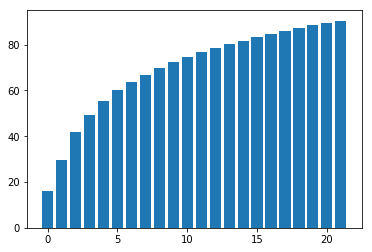

In [ ]:
total = sum(pca.explained_variance_)
k = 0
current_variance = 0
while current_variance/total < 0.90:
    current_variance += pca.explained_variance_[k]
    k = k + 1

print(k, " features explain around 90% of the variance. From 7129 features to ", k, ", not too bad.", sep='')

pca = PCA(n_components=k)
X_train.pca = pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

var_exp = pca.explained_variance_ratio_.cumsum()
var_exp = var_exp*100
plt.bar(range(k), var_exp);

We can't plot something in 22 dimensions, so let's just see what the PCA looks like when we just pick the top three compoments. (Here we are using code taken from [this kernel](https://www.kaggle.com/kanav0183/pca-analysis-for-geneclassification).)

[]

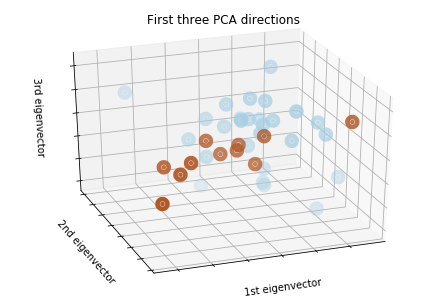

In [ ]:
pca3 = PCA(n_components=3).fit(X_train)
X_train_reduced = pca3.transform(X_train)

plt.clf()
fig = plt.figure(1, figsize=(10,6 ))
ax = Axes3D(fig, elev=-150, azim=110,)
ax.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], X_train_reduced[:, 2], c = y_train.iloc[:,1], cmap = plt.cm.Paired, linewidths=10)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

Text(0.5, 1.0, '2D Transformation of the Above Graph ')

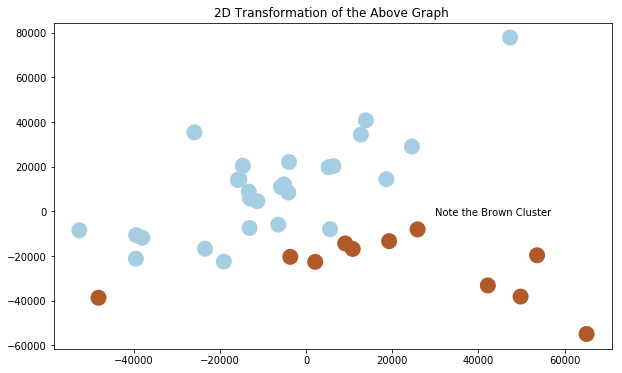

In [ ]:
fig = plt.figure(1, figsize = (10, 6))
plt.scatter(X_train_reduced[:, 0],  X_train_reduced[:, 1], c = y_train.iloc[:,1], cmap = plt.cm.Paired, linewidths=10)
plt.annotate('Note the Brown Cluster', xy = (30000,-2000))
plt.title("2D Transformation of the Above Graph ")

## **Confussion Matrix**

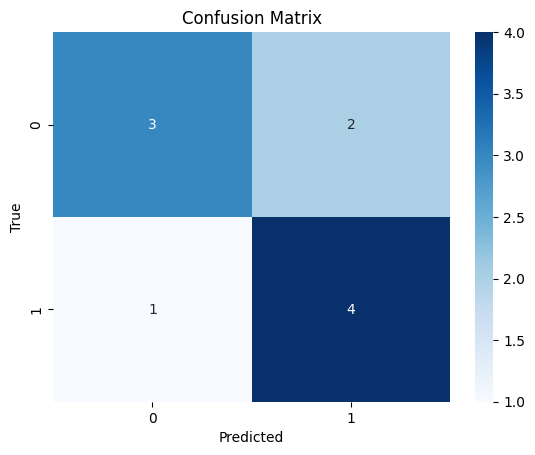

In [ ]:
# Heatmap com seaborn:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Dados de exemplo
y_true = [0, 1, 0, 0, 1, 1, 0, 1, 1, 0]
y_pred = [0, 1, 1, 0, 1, 1, 0, 0, 1, 1]

# Criação da matriz de confusão
cm = confusion_matrix(y_true, y_pred)

# Criação de um heatmap para visualização da matriz de confusão
sns.heatmap(cm, annot=True, cmap='Blues')

# Configurações adicionais
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Exibição da matriz de confusão
plt.show()


In [ ]:
            | Classe A | Classe B | Classe C |
---------------------------------------------
Classe A    |   TP     |   FN     |   FN     |
---------------------------------------------
Classe B    |   FP     |   TP     |   FP     |
---------------------------------------------
Classe C    |   FN     |   FP     |   TP     |
---------------------------------------------


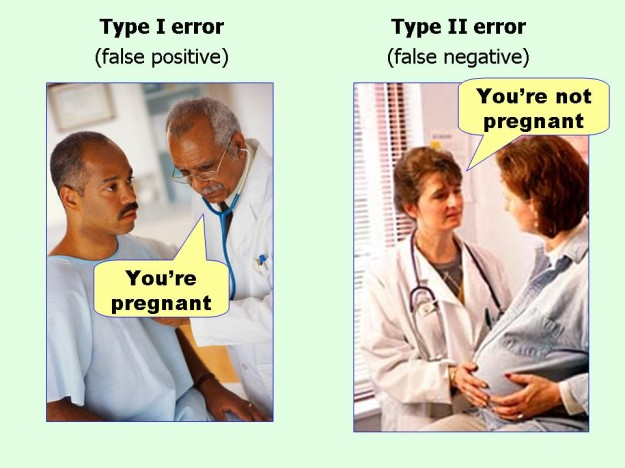

Fonte: https://mineracaodedados.wordpress.com/2014/05/18/erro-tipo-i-e-erro-tipo-ii-exemplificado-com-imagens/

Elemento na posição (0,0): representa a quantidade de classificações Verdadeiros Positivos, ou seja, a quantidade de vezes que o modelo acertou a predição positiva conforme os dados reais. No exemplo, o classificador previu corretamente 3 casos.
Elemento na posição (0,1): representa a quantidade de classificações Falsos Negativos, ou seja, a quantidade de vezes que o modelo previu incorretamente um resultado como negativo. No exemplo, o classificador previu incorretamente 2 casos.
Elemento na posição (1,0): representa a quantidade de classificações Falsos Positivos, ou seja, a quantidade de vezes que o modelo previu incorretamente um resultado como positivo. No exemplo, o classificador previu incorretamente 1 casos.
Elemento na posição (1,1): representa a quantidade de classificações Verdadeiros Negativos, ou seja, a quantidade de vezes que o modelo acertou a predição negativa conforme os dados reais. No exemplo, o classificador previu corretamente 4 casos.

Fonte: https://cursos.alura.com.br/forum/topico-como-interpretar-os-dados-da-matriz-de-confusao-180461

In [ ]:
# Tabela com pandas:
import pandas as pd
from sklearn.metrics import confusion_matrix

# Dados de exemplo
y_true = [0, 1, 0, 0, 1, 1, 0, 1, 1, 0]
y_pred = [0, 1, 1, 0, 1, 1, 0, 0, 1, 1]

# Criação da matriz de confusão
cm = confusion_matrix(y_true, y_pred)

# Criação de um DataFrame com a matriz de confusão
df_cm = pd.DataFrame(cm, index=['True 0', 'True 1'], columns=['Pred 0', 'Pred 1'])

# Exibição da tabela da matriz de confusão
print(df_cm)


        Pred 0  Pred 1
True 0       3       2
True 1       1       4


A matriz de confusão, também conhecida como tabela de contingência, é uma ferramenta de avaliação de desempenho de modelos de classificação em aprendizado de máquina. Ela permite visualizar e analisar a relação entre as classes reais e as classes previstas pelo modelo.

A matriz de confusão é organizada em uma tabela de dimensões NxN, onde N é o número de classes. Cada célula da matriz representa uma contagem ou frequência, mostrando a quantidade de instâncias que pertencem a determinada classe real e foram classificadas em uma determinada classe prevista.

A matriz de confusão tem as seguintes células:

Verdadeiro Positivo (TP): representa as instâncias corretamente classificadas como positivas.
Falso Positivo (FP): representa as instâncias erroneamente classificadas como positivas, quando na verdade são negativas.
Verdadeiro Negativo (TN): representa as instâncias corretamente classificadas como negativas.
Falso Negativo (FN): representa as instâncias erroneamente classificadas como negativas, quando na verdade são positivas.
Essas células permitem calcular várias métricas de avaliação do modelo, como precisão (accuracy), recall, especificidade, F1-score, entre outras.

A visualização da matriz de confusão pode ser feita usando um heatmap, onde as células são coloridas de acordo com seus valores. Isso facilita a identificação de padrões e discrepâncias nas classificações do modelo.

Ao analisar a matriz de confusão, podemos obter insights sobre o desempenho do modelo em relação a cada classe. Podemos identificar se o modelo tem tendência a confundir algumas classes específicas, se há um desequilíbrio entre as classes, ou se o modelo está produzindo muitos falsos positivos ou falsos negativos.

Em resumo, a matriz de confusão é uma ferramenta essencial para a avaliação de modelos de classificação, fornecendo uma visão clara e quantitativa do desempenho do modelo em relação às classes reais.

A matriz de confusão é uma tabela que permite visualizar o desempenho de um modelo de classificação em termos de acertos e erros para cada classe. A partir dessa matriz, é possível calcular várias métricas que fornecem informações adicionais sobre o desempenho do modelo. As principais métricas obtidas a partir da matriz de confusão incluem:

Acurácia (Accuracy): É a proporção de predições corretas em relação ao total de predições. É calculada pela soma dos elementos da diagonal principal da matriz de confusão dividida pelo total de elementos.

Acurácia = (Verdadeiros Positivos + Verdadeiros Negativos) / (Verdadeiros Positivos + Falsos Positivos + Falsos Negativos + Verdadeiros Negativos)

Precisão (Precision): Mede a proporção de verdadeiros positivos em relação a todas as predições positivas. É calculada pela divisão dos verdadeiros positivos pelo somatório dos verdadeiros positivos e falsos positivos.

Precisão = Verdadeiros Positivos / (Verdadeiros Positivos + Falsos Positivos)

Recall ou Sensibilidade (Recall/Sensitivity): Mede a proporção de verdadeiros positivos em relação a todos os exemplos positivos reais. É calculado pela divisão dos verdadeiros positivos pelo somatório dos verdadeiros positivos e falsos negativos.

Recall = Verdadeiros Positivos / (Verdadeiros Positivos + Falsos Negativos)

F1-Score: É uma medida que combina a precisão e o recall em um único valor. É calculado pela média harmônica entre a precisão e o recall.

F1-Score = 2 * (Precisão * Recall) / (Precisão + Recall)

Essas são apenas algumas das métricas comumente usadas. Dependendo do problema e das características dos dados, outras métricas podem ser relevantes, como a especificidade, a taxa de falso positivo, a taxa de falso negativo, entre outras. É importante escolher as métricas que melhor se adequam ao contexto e aos objetivos do problema de classificação em questão.

## Model Building

Having prepared the dataset, it's now finally time to try out some models.

### Baseline

Let's start by establishing a naive baseline. This doesn't require a model, we are just taking the proportion of tests that belong to the majority class as a baseline. In other words, let's see what happens if we were to predict that every patient belongs to the "ALL" class.

In [ ]:
print("Simply predicting everything as acute lymphoblastic leukemia (ALL) results in an accuracy of ", round(1 - np.mean(y_test.iloc[:,1]), 3), ".", sep = '')

Simply predicting everything as acute lymphoblastic leukemia (ALL) results in an accuracy of 0.588.


### K-Means Clustering

First we shall try an unsupervised clustering approach using the scaled data.

K-means accuracy: 0.765


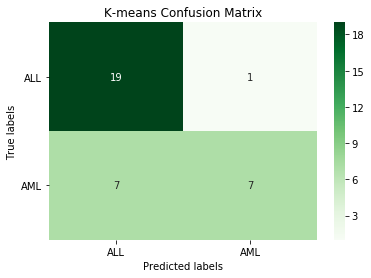

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_train_scl)
km_pred = kmeans.predict(X_test_scl)

print('K-means accuracy:', round(accuracy_score(y_test.iloc[:,1], km_pred), 3))

cm_km = confusion_matrix(y_test.iloc[:,1], km_pred)

ax = plt.subplot()
sns.heatmap(cm_km, annot=True, ax = ax, fmt='g', cmap='Greens')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('K-means Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360);

This K-means approach is better than the baseline, but we should be able to do better with some kind of supervised learning model.

### Naive Bayes

For our first supervised model, we shall use a very straightforward naive bayes approach.

Naive Bayes accuracy: 0.912


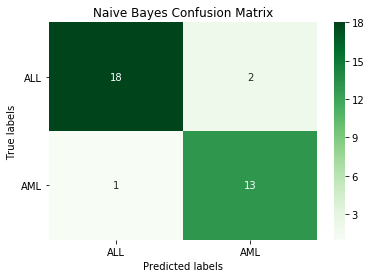

In [ ]:
# Create a Gaussian classifier
nb_model = GaussianNB()

nb_model.fit(X_train, y_train.iloc[:,1])

nb_pred = nb_model.predict(X_test)

print('Naive Bayes accuracy:', round(accuracy_score(y_test.iloc[:,1], nb_pred), 3))

cm_nb =  confusion_matrix(y_test.iloc[:,1], nb_pred)

ax = plt.subplot()
sns.heatmap(cm_nb, annot=True, ax = ax, fmt='g', cmap='Greens')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Naive Bayes Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360);

The naive bayes model is pretty good, just three incorrect classifications.

### Logistic Regression

Another very standard approach is logistic regression. Here we will be using grid search cross-validation tuning to try and determine the best hyperparameters. We don't need to scale the data for logistic regression, nor are we using the PCA version of the dataset.

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Parameters:
 {'C': 1, 'penalty': 'l1'}
Logistic Regression accuracy: 1.0


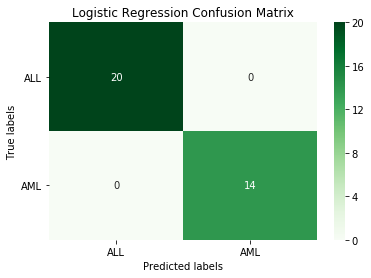

In [ ]:
log_grid = {'C': [1e-03, 1e-2, 1e-1, 1, 10],
                 'penalty': ['l1', 'l2']}

log_estimator = LogisticRegression(solver='liblinear')

log_model = GridSearchCV(estimator=log_estimator,
                  param_grid=log_grid,
                  cv=3,
                  scoring='accuracy')

log_model.fit(X_train, y_train.iloc[:,1])

print("Best Parameters:\n", log_model.best_params_)

# Select best log model
best_log = log_model.best_estimator_

# Make predictions using the optimised parameters
log_pred = best_log.predict(X_test)

print('Logistic Regression accuracy:', round(accuracy_score(y_test.iloc[:,1], log_pred), 3))

cm_log =  confusion_matrix(y_test.iloc[:,1], log_pred)

ax = plt.subplot()
sns.heatmap(cm_log, annot=True, ax = ax, fmt='g', cmap='Greens')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Logistic Regression Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360);

This logistic regression model manages perfect classification.

### Support Vector Machine

Here we will try another traditional approach, a support vector machine (SVM) classifier. For the SVM, so we using the PCA version of the dataset. Again we use grid search cross-validation to tune the model.

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Parameters:
 {'C': 0.1, 'decision_function_shape': 'ovo', 'gamma': 1, 'kernel': 'linear'}
SVM accuracy: 0.941


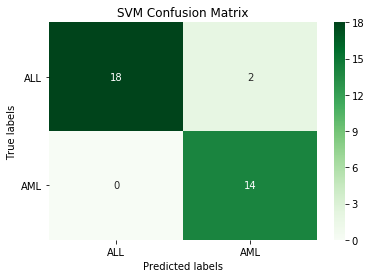

In [ ]:
# Parameter grid
svm_param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001, 0.00001, 10], "kernel": ["linear", "rbf", "poly"], "decision_function_shape" : ["ovo", "ovr"]}

# Create SVM grid search classifier
svm_grid = GridSearchCV(SVC(), svm_param_grid, cv=3)

# Train the classifier
svm_grid.fit(X_train_pca, y_train.iloc[:,1])

print("Best Parameters:\n", svm_grid.best_params_)

# Select best svc
best_svc = svm_grid.best_estimator_

# Make predictions using the optimised parameters
svm_pred = best_svc.predict(X_test_pca)

print('SVM accuracy:', round(accuracy_score(y_test.iloc[:,1], svm_pred), 3))

cm_svm =  confusion_matrix(y_test.iloc[:,1], svm_pred)

ax = plt.subplot()
sns.heatmap(cm_svm, annot=True, ax = ax, fmt='g', cmap='Greens')

# Labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('SVM Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360);

This SVM model is making just a couple of classification errors.

### Random Forest

We now move on to tree-base approaches, starting with the very popular random forest. We don't need scaled data for this, so again we wont use the scaled version of the dataset, just a grid search for tuning the hyperparameters.

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Parameters:
 {'bootstrap': False, 'max_features': 0.6, 'min_samples_leaf': 8, 'min_samples_split': 3, 'n_estimators': 60}
Random Forest accuracy: 0.912


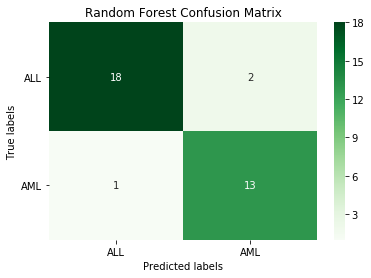

In [ ]:
# Hyperparameters search grid
rf_param_grid = {'bootstrap': [False, True],
         'n_estimators': [60, 70, 80, 90, 100],
         'max_features': [0.6, 0.65, 0.7, 0.75, 0.8],
         'min_samples_leaf': [8, 10, 12, 14],
         'min_samples_split': [3, 5, 7]
        }

# Instantiate random forest classifier
rf_estimator = RandomForestClassifier(random_state=0)

# Create the GridSearchCV object
rf_model = GridSearchCV(estimator=rf_estimator, param_grid=rf_param_grid, cv=3, scoring='accuracy')

# Fine-tune the hyperparameters
rf_model.fit(X_train, y_train.iloc[:,1])

print("Best Parameters:\n", rf_model.best_params_)

# Get the best model
rf_model_best = rf_model.best_estimator_

# Make predictions using the optimised parameters
rf_pred = rf_model_best.predict(X_test)

print('Random Forest accuracy:', round(accuracy_score(y_test.iloc[:,1], rf_pred), 3))

cm_rf = confusion_matrix(y_test.iloc[:,1], rf_pred)

ax = plt.subplot()
sns.heatmap(cm_rf, annot=True, ax = ax, fmt='g', cmap='Greens')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Random Forest Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360);

Random forest almost matches the SVM performance.

### XG Boost

Nowadays, gradient boosting models such as XG Boost(XGB) are extremely popular. Here we shall experiment with three alternative versions, PCA with grid search, PCA without grid search and also the orginal data without either PCA or grid search.

#### XGB — PCA with Grid Search

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Parameters:
 {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 130}
XGB (PCA with Grid Search) accuracy: 0.794


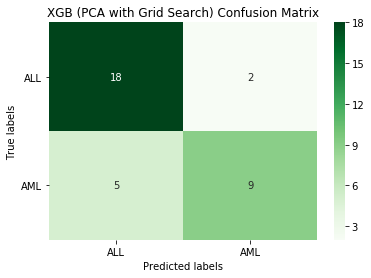

In [ ]:
xgb_grid_params = {'max_depth': [3, 4, 5, 6, 7, 8, 10, 12],
               'min_child_weight': [1, 2, 4, 6, 8, 10, 12, 15],
               'n_estimators': [40, 50, 60, 70, 80, 90, 100, 110, 120, 130],
               'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3]}

fixed_params = {'random_state': 0,
                'n_jobs': -1}

xgb_model = GridSearchCV(xgb.XGBClassifier(**fixed_params),
                       param_grid = xgb_grid_params,
                       scoring = 'accuracy',
                       cv = 3)

xgb_model.fit(X_train_pca, y_train.iloc[:,1])

print("Best Parameters:\n", xgb_model.best_params_)

# Get the best model
xgb_model_best = xgb_model.best_estimator_

# Make predictions using the optimised parameters
xgb_pred = xgb_model_best.predict(X_test_pca)

print('XGB (PCA with Grid Search) accuracy:', round(accuracy_score(y_test.iloc[:,1], xgb_pred), 3))

cm_xgb = confusion_matrix(y_test.iloc[:,1], xgb_pred)

ax = plt.subplot()
sns.heatmap(cm_xgb, annot=True, ax = ax, fmt='g', cmap='Greens')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('XGB (PCA with Grid Search) Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360);

XGB with PCA and grid search isn't particularly good.

#### XGB — PCA with no Grid Search

Accuracy:  0.824


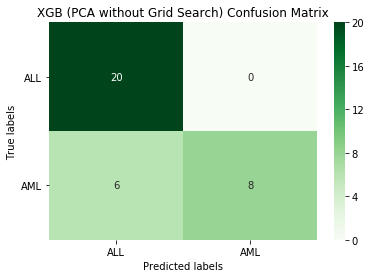

In [ ]:
xgb2_model = xgb.XGBClassifier()
xgb2_model.fit(X_train_pca, y_train.iloc[:,1])

xgb2_pred = xgb2_model.predict(X_test_pca)

print('Accuracy: ', round(accuracy_score(y_test.iloc[:,1], xgb2_pred), 3))

cm_xgb2 = confusion_matrix(y_test.iloc[:,1], xgb2_pred)

ax = plt.subplot()
sns.heatmap(cm_xgb2, annot=True, ax = ax, fmt='g', cmap='Greens')

# Labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('XGB (PCA without Grid Search) Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360);

Without the grid search, this is barely any better. However, it seems that the grid search may possibly be resulting in some overfitting.

#### XGB — no PCA or Grid Search

XGB (no PCA or Grid Search) accuracy: 0.912


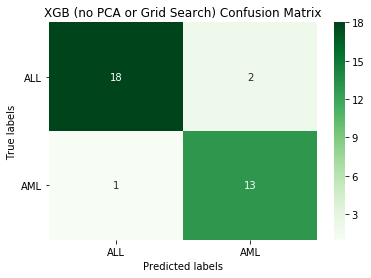

In [ ]:
xgb3_model = xgb.XGBClassifier()
xgb3_model.fit(X_train, y_train.iloc[:,1])

xgb3_pred = xgb3_model.predict(X_test)

print('XGB (no PCA or Grid Search) accuracy:', round(accuracy_score(y_test.iloc[:,1], xgb3_pred), 3))

cm_xgb3 = confusion_matrix(y_test.iloc[:,1], xgb3_pred)

ax = plt.subplot()
sns.heatmap(cm_xgb3, annot=True, ax = ax, fmt='g', cmap='Greens')

# Labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('XGB (no PCA or Grid Search) Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360);

OK, that's more like it. It seems that the PCA was actually the wrong approach for the XGB model.

### Neural Network

Finally we shall build a neural network using Keras (with TensorFlow as a backend). This only a "shallow" learning model with one hidden layer — adding several extra layers with so few training datapoints would just lead to overfitting.

In [ ]:
# Create model architecture
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(7129,)))
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
# Compile model
model.compile(optimizer='adam',
loss='binary_crossentropy',
metrics=['accuracy'])

In [ ]:
# Create training/validation sets
partial_X_train = X_train_scl[:30]
X_val = X_train_scl[30:]

y_train_label = y_train.iloc[:,1]
partial_y_train = y_train_label[:30]
y_val = y_train_label[30:]

In [ ]:
# Set up early stopping
es = EarlyStopping(monitor='val_loss', verbose=1, patience=3)

# Fit model
history = model.fit(partial_X_train,
            partial_y_train,
            epochs=50,
            batch_size=4,
            validation_data=(X_val, y_val),
            callbacks=[es])

Instructions for updating:
Use tf.cast instead.
Train on 30 samples, validate on 8 samples
Epoch 1/50
30/30 [==============================] - 1s 23ms/step - loss: 0.8691 - acc: 0.5667 - val_loss: 0.0285 - val_acc: 1.0000
Epoch 2/50
30/30 [==============================] - 0s 872us/step - loss: 0.0773 - acc: 1.0000 - val_loss: 0.1409 - val_acc: 0.8750
Epoch 3/50
30/30 [==============================] - 0s 826us/step - loss: 0.0165 - acc: 1.0000 - val_loss: 0.2085 - val_acc: 0.8750
Epoch 4/50
30/30 [==============================] - 0s 1ms/step - loss: 0.0083 - acc: 1.0000 - val_loss: 0.2491 - val_acc: 0.8750
Epoch 00004: early stopping


Neural Network accuracy:  0.706


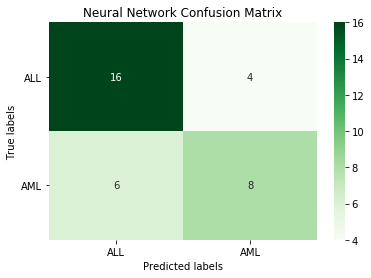

In [ ]:
# Make predictions
nn_pred = model.predict_classes(X_test_scl)

print('Neural Network accuracy: ', round(accuracy_score(y_test.iloc[:,1], nn_pred), 3))

cm_nn = confusion_matrix(y_test.iloc[:,1], nn_pred)

ax = plt.subplot()
sns.heatmap(cm_nn, annot=True, ax = ax, fmt='g', cmap='Greens')

# Labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Neural Network Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360);

The neural network isn't as good as some of the other models.

In conclusion, it was the logistic regression model that provided the best performance on this dataset.